In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix

#Files
import h5py
import glob
import seaborn as sns

In [2]:
f=h5py.File(r'features_database_gait_one_cycles_both_legs.h5', 'r')
print(list(f.keys()))
x = f['right'][:,:,:]
print('(samples, timesteps, features)', x.shape)

['left', 'right']
(samples, timesteps, features) (74, 132, 7)


In [3]:
path = f'cut_one_gait_cycle_right'
filelist =[]
digits =[]
digits_int =[]
for file in glob.glob(f'{path}\\*.c3d',recursive = True):
    filelist.append(file[4:-4].replace("_", ""))
    digits.append(file[25:-9])

for ele in digits:
    digits_int.append(1) if ele=='degeneration' else digits_int.append(0)

In [4]:
nsamples, nx, ny = x.shape
d2_x = x.reshape((nsamples,nx*ny))

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(d2_x)
scaled_data

array([[-0.92125674, -0.6165565 , -0.69867153, ...,  0.1108021 ,
        -1.26665914, -0.17671998],
       [-1.29455354, -0.3242606 , -0.44893282, ..., -0.206346  ,
        -0.59028727, -1.36097123],
       [-0.85459138, -0.60811885, -0.7751116 , ..., -0.34795983,
         0.28792832, -0.34046659],
       ...,
       [ 1.03513362, -0.76945603, -1.2987694 , ...,  0.65662284,
         1.00996164,  0.90237715],
       [ 1.908187  , -0.90759249, -0.6421859 , ...,  0.61504368,
        -0.57523387, -1.39050083],
       [ 1.03513362, -0.76945603, -1.2987694 , ...,  0.65662284,
         1.00996164,  0.90237715]])

In [6]:
components = min(74, 7)
pca = PCA(n_components=components, svd_solver='full')
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

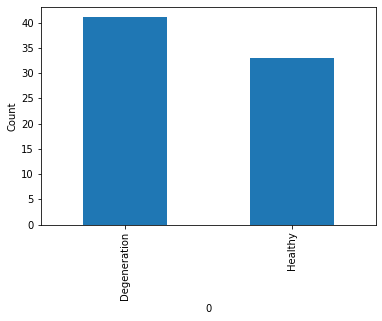

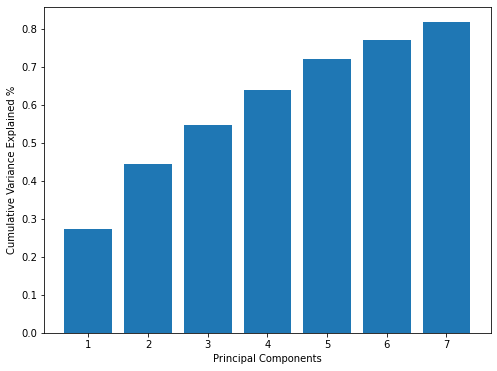

In [7]:
# Calculate cumulative explained variance across all PCs

cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)
    
# Visualize class distribution

pd.DataFrame(digits_int).value_counts().plot(kind='bar')
plt.xticks([0,1], ['Degeneration', 'Healthy'])
plt.ylabel('Count');
    
# Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,8), cum_exp_var)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Cumulative Variance Explained %');

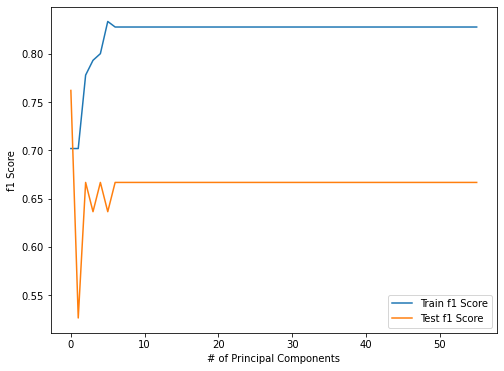

In [8]:
train_f1 = []
test_f1 = []

for i in range(56):
    
    X = X_pca[:,0:i+1]
    
    # Train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                        test_size=0.25,
                                                        random_state=42)

    # Perform feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit k-NN classifier and make predictions
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    train_f1.append(f1_score(y_train, y_pred_train))
    test_f1.append(f1_score(y_test, y_pred_test))

# Plot accuracy by n_neighbors
plt.figure(figsize=(8, 6))
plt.plot(range(0,56), train_f1, label='Train f1 Score')
plt.plot(range(0,56), test_f1, label='Test f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('# of Principal Components')
plt.legend()
plt.show()

In [9]:
X = scaled_data[:,0:56]
    
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                    test_size=0.25,
                                                    random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit k-NN classifier and make predictions
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)
    
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.8620689655172413
Test f1 Score: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.43      0.43      0.43         7
           1       0.67      0.67      0.67        12

    accuracy                           0.58        19
   macro avg       0.55      0.55      0.55        19
weighted avg       0.58      0.58      0.58        19



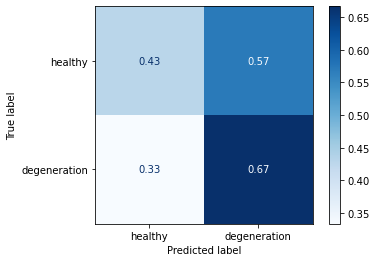

In [10]:
plot_confusion_matrix(knn, X_test, y_test, display_labels=['healthy','degeneration'],
                      normalize='true', cmap='Blues');

Text(0, 0.5, 'Second Principal Component')

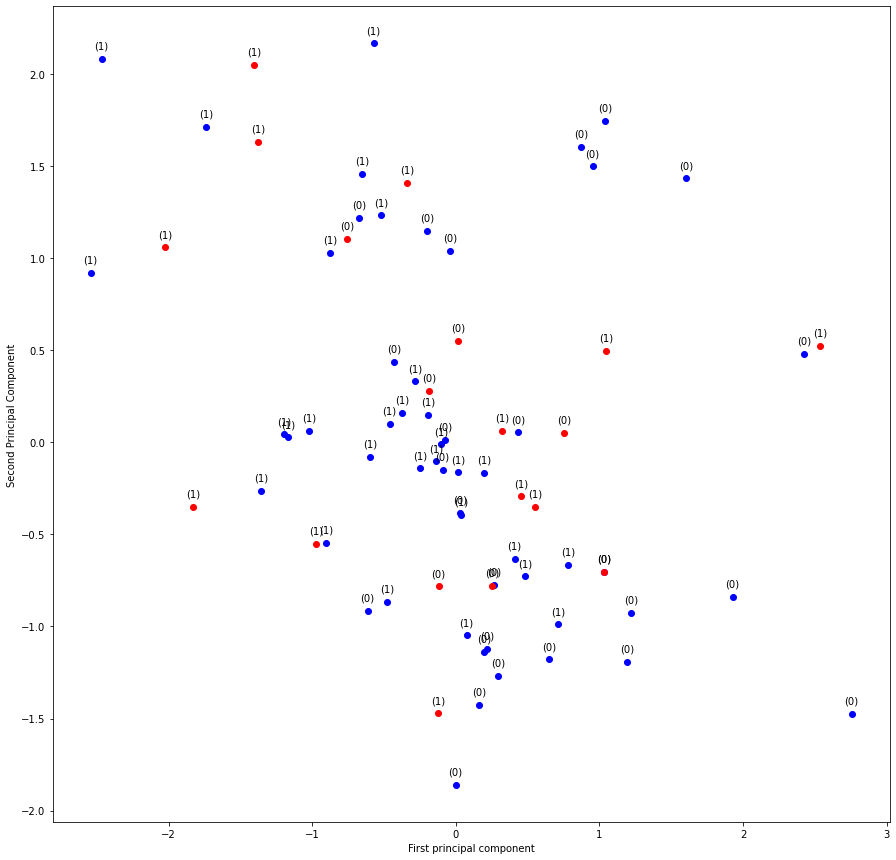

In [14]:
plt.figure(figsize=(15,15))
plt.scatter(X_train[:,0],X_train[:,1], c='blue')
for x,y,z in zip(X_train[:,0],X_train[:,1], y_pred_train):
    label = f"({z})"
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')

plt.scatter(X_test[:,0],X_test[:,1], c='red')
for x,y,z in zip(X_test[:,0],X_test[:,1], y_pred_test):
    label = f"({z})"
    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='center')
    
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')